In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data =pd.read_csv("220223_data_reflectorFed_xyz.csv")

In [4]:
x= data['x']
y=data['y']
z=data['z']

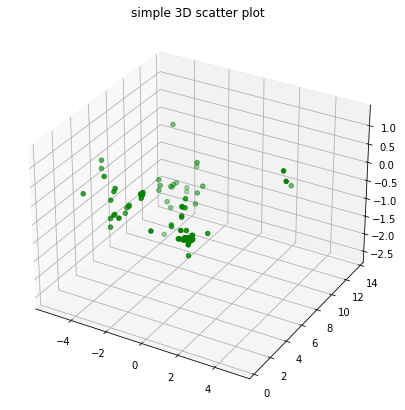

In [5]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [6]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(n_clusters=3)

In [13]:
kmeans.fit(data)

KMeans(n_clusters=3)

In [14]:
kmeans.cluster_centers_

array([[ 0.58442982,  3.0312384 , -0.23932369],
       [-2.98688134, 10.98959819, -1.19338309],
       [-3.34130892,  3.96502365, -0.37152215]])

In [15]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

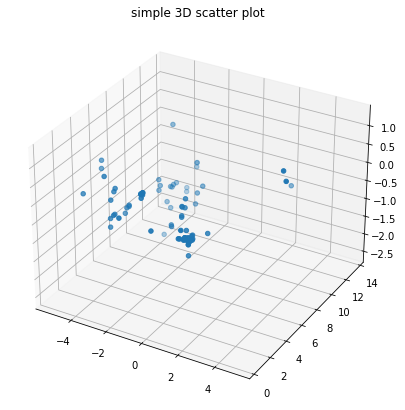

In [16]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x,y,z, cmap = "rainbow")
plt.title("simple 3D scatter plot")
# show plot
plt.show()